In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import re
import os
import sys
import subprocess
import logging
import itertools
from collections import defaultdict
from IPython.display import HTML, Image, display


import ipywidgets as widgets

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S', stream=sys.stdout)

sns.set(style="darkgrid", font_scale=1.2)
print("numpy {}, pandas {}, seaborn: {}".format(
    np.__version__, pd.__version__, sns.__version__
))

numpy 1.18.5, pandas 1.1.1, seaborn: 0.10.0


# load data

In [2]:
DATA_DIR = "data"

In [3]:
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))
shops = pd.read_csv(os.path.join(DATA_DIR, 'shops.csv'))
item_cats = pd.read_csv(os.path.join(DATA_DIR, 'item_categories.csv'))
train = pd.read_csv(os.path.join(DATA_DIR, 'sales_train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [4]:
len(items), len(shops), len(item_cats), len(train), len(test)

(22170, 60, 84, 2935849, 214200)

In [5]:
train.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1660704,25.05.2014,16,21,4353,1999.0,1.0
2301193,28.12.2014,23,57,3341,1999.0,1.0
1828144,07.07.2014,18,10,20302,312.0,1.0
1456894,05.03.2014,14,50,17865,169.0,1.0
814545,13.08.2013,7,25,17896,149.0,1.0
1727573,09.06.2014,17,7,7805,699.0,1.0
2440610,28.02.2015,25,49,20448,399.0,1.0
907722,06.09.2013,8,27,4291,299.0,1.0
1969735,10.09.2014,20,51,8624,69.0,1.0
709213,03.07.2013,6,56,21924,349.0,1.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
# null checking
train.isnull().sum()


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# Monthly Sales

In [8]:
# convert the date column to datetime object
train["date"] = pd.to_datetime(train["date"], format = "%d.%m.%Y")

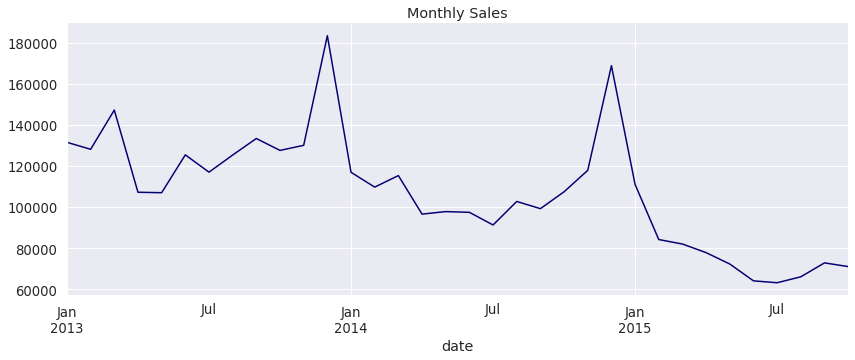

In [9]:
# resample the data on a monthly basis
train.set_index("date")['item_cnt_day'].resample("M").sum() \
     .plot(kind='line', color=sns.xkcd_rgb['deep blue'], figsize=(14, 5), rot=0)\
     .set(title='Monthly Sales')
sns.despine()
plt.show()

This figure shows the overall monthly sales happening across all shops and items. Observation:
* we see big spikes in the holiday season before January
* there is a general downward trend in the entire time span, which inspire us to design features than can capture such trend

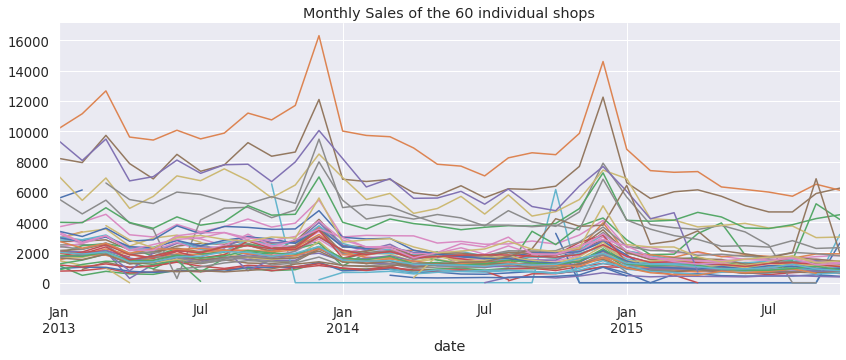

In [10]:
train.set_index("date").groupby('shop_id')['item_cnt_day'].resample("M").sum() \
     .unstack(level=0) \
     .plot(kind='line', figsize=(14, 5), rot=0, legend=False) \
     .set(title='Monthly Sales of the 60 individual shops')
sns.despine()
plt.show()

This figure shows the monthly sales of the 60 individual shops. Each line represents one shop. Observation:

* each shop more or less follows the general trend we observe above, with a few exceptions
* majority of the shops have low sales compared to a few with large volume of sales

In [11]:
train = pd.merge(train, items, on=['item_id'], how='left')
train = pd.merge(train, item_cats, on=['item_category_id'], how='left')

In [12]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


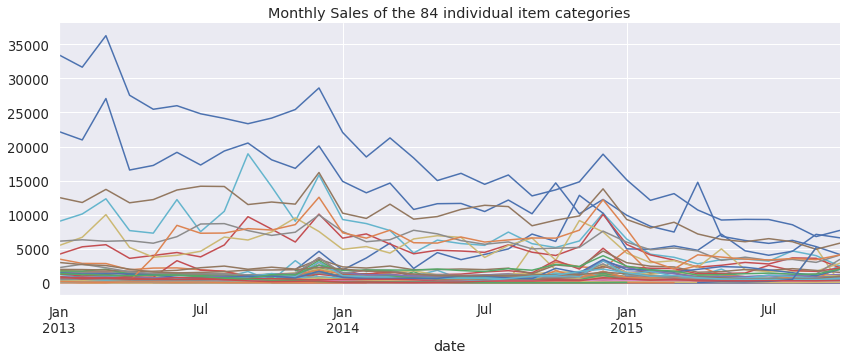

In [13]:
train.set_index("date").groupby('item_category_id')['item_cnt_day'].resample("M").sum() \
     .unstack(level=0) \
     .plot(kind='line', figsize=(14, 5), rot=0, legend=False) \
     .set(title='Monthly Sales of the 84 individual item categories')
sns.despine()
plt.show()

This figure shows the monthly sales of the 84 individual item categories. Each line represents one item category. Observations:

* each category has a downward overall trend in the time span
* majority of the categories have low sales compared to a few with large volume of sales

# Outliers in price and item_cnt_day

Text(0.5, 1.0, 'Box plot of item_cnt_day')

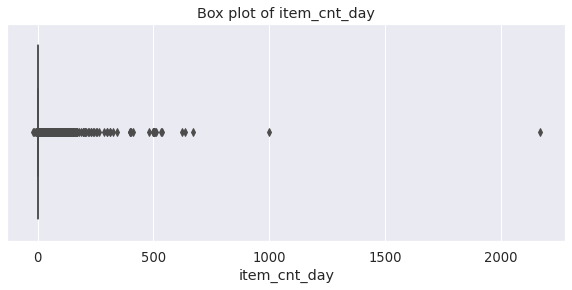

In [14]:
plt.figure(figsize = (10,4))
sns.boxplot(x = train["item_cnt_day"])
plt.title('Box plot of item_cnt_day')

Most majority of the item_cnt_day is smaller than 1000. We can filter out data points with item_cnt_day >= 1000.

Text(0.5, 1.0, 'Box plot of item_price')

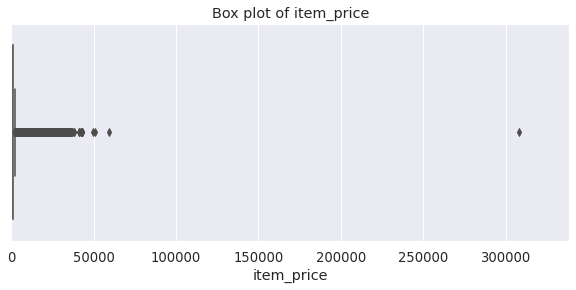

In [15]:
plt.figure(figsize = (10,4))
plt.xlim(train["item_price"].min(), train["item_price"].max()*1.1)
sns.boxplot(x = train["item_price"])
plt.title('Box plot of item_price')

There is one sales with item_price > 300000, which is a clear outlier.

# A closer look at the train data

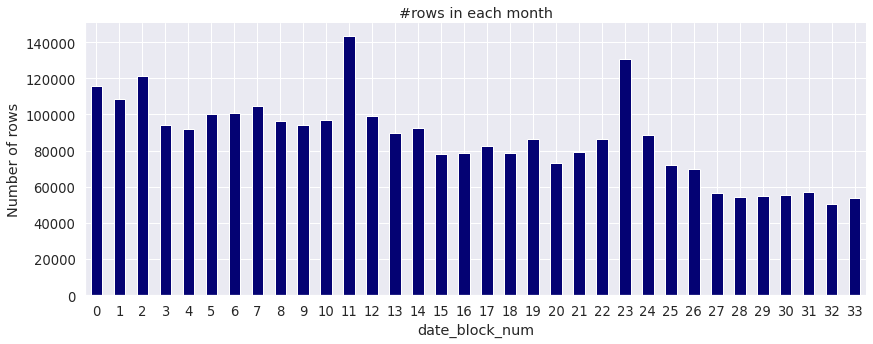

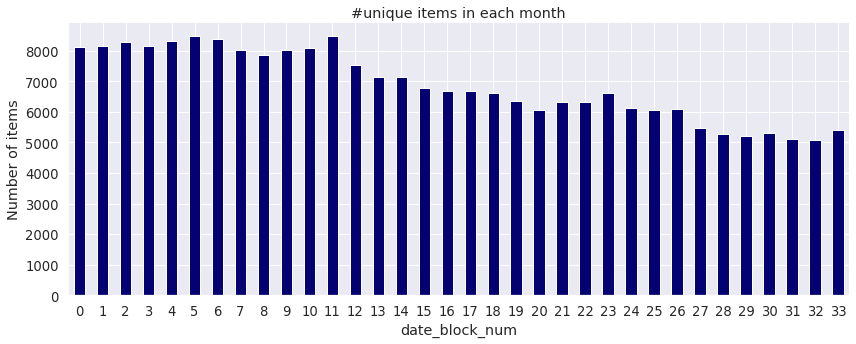

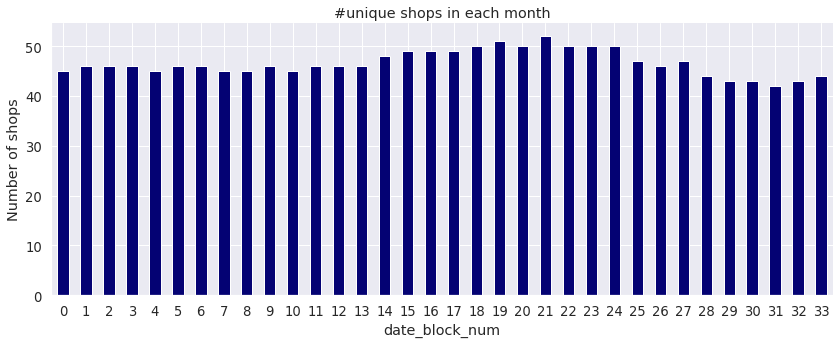

In [16]:
train.groupby('date_block_num').size()\
    .plot(kind='bar', color=sns.xkcd_rgb['deep blue'], figsize=(14,5), rot=0)\
    .set(ylabel="Number of rows", title='#rows in each month')
sns.despine()
plt.show()

train.groupby('date_block_num')['item_id'].nunique()\
    .plot(kind='bar', color=sns.xkcd_rgb['deep blue'], figsize=(14,5), rot=0)\
    .set(ylabel="Number of items", title='#unique items in each month')
sns.despine()
plt.show()

train.groupby('date_block_num')['shop_id'].nunique()\
    .plot(kind='bar', color=sns.xkcd_rgb['deep blue'], figsize=(14,5), rot=0)\
    .set(ylabel="Number of shops", title='#unique shops in each month')
sns.despine()
plt.show()

We can see that in each month, only a subset of items or shops have sales. 

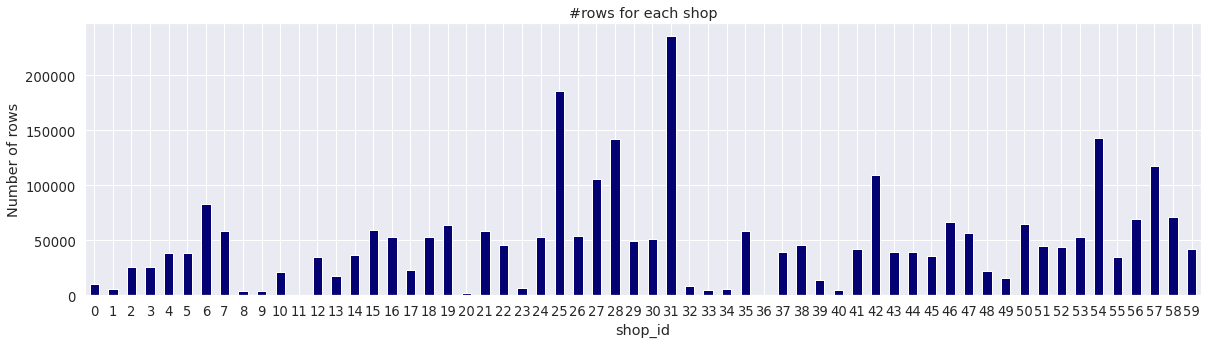

In [17]:
train.groupby('shop_id').size()\
    .plot(kind='bar', color=sns.xkcd_rgb['deep blue'], figsize=(20,5), rot=0)\
    .set(ylabel="Number of rows", title='#rows for each shop')
plt.show()

Some shops really have a lot of transactions in the train data, while some have very few. We should somehow extract features to represent shop characteristics. 

# New items in each month

In [24]:
logging.info("calculcate months on the market for items")
shop_first_month = train.groupby('item_id')['date_block_num'].min()
train['months_on_market'] = train['date_block_num'] - train['item_id'].map(shop_first_month)


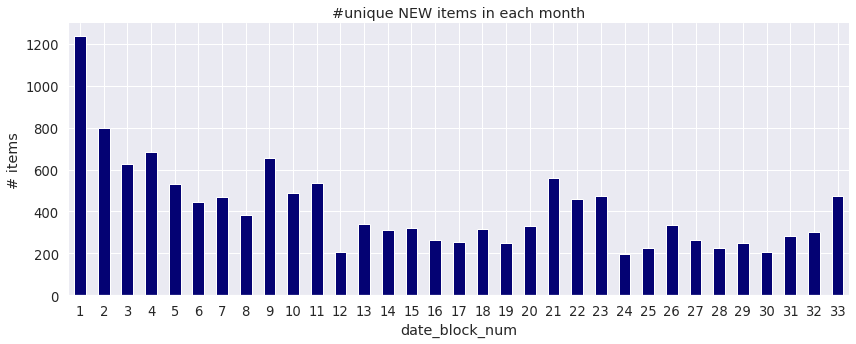

In [29]:
train.loc[(train.months_on_market==0) & (train.date_block_num > 0), :] \
     .groupby('date_block_num')['item_id'].nunique() \
     .plot(kind='bar', rot=0, color=sns.xkcd_rgb['deep blue'], figsize=(14,5)) \
     .set(ylabel="# items", title="#unique NEW items in each month")
sns.despine()
plt.show()

There are around hundreds of new items each month on the market

In [37]:
new_in_test = test.loc[~test.item_id.isin(train.item_id), 'item_id'].nunique()
print("there are {} new items in the test not in the train \n".format(new_in_test))

there are 363 new items in the test not in the train 



Given the number of new items that have never appeared in the train data, it is a challenge to have a prediction on them. As a result, we should extract good features at the shop level, the item category level, as well as the item names to address this "cold start" problem.